In [1]:
%matplotlib inline
from scrape.graph import create_graph_images, generate_boxplot_ci, generate_boxplot_ci_error, generate_boxplot_ci_error_for_days, generate_plot_ci_lines

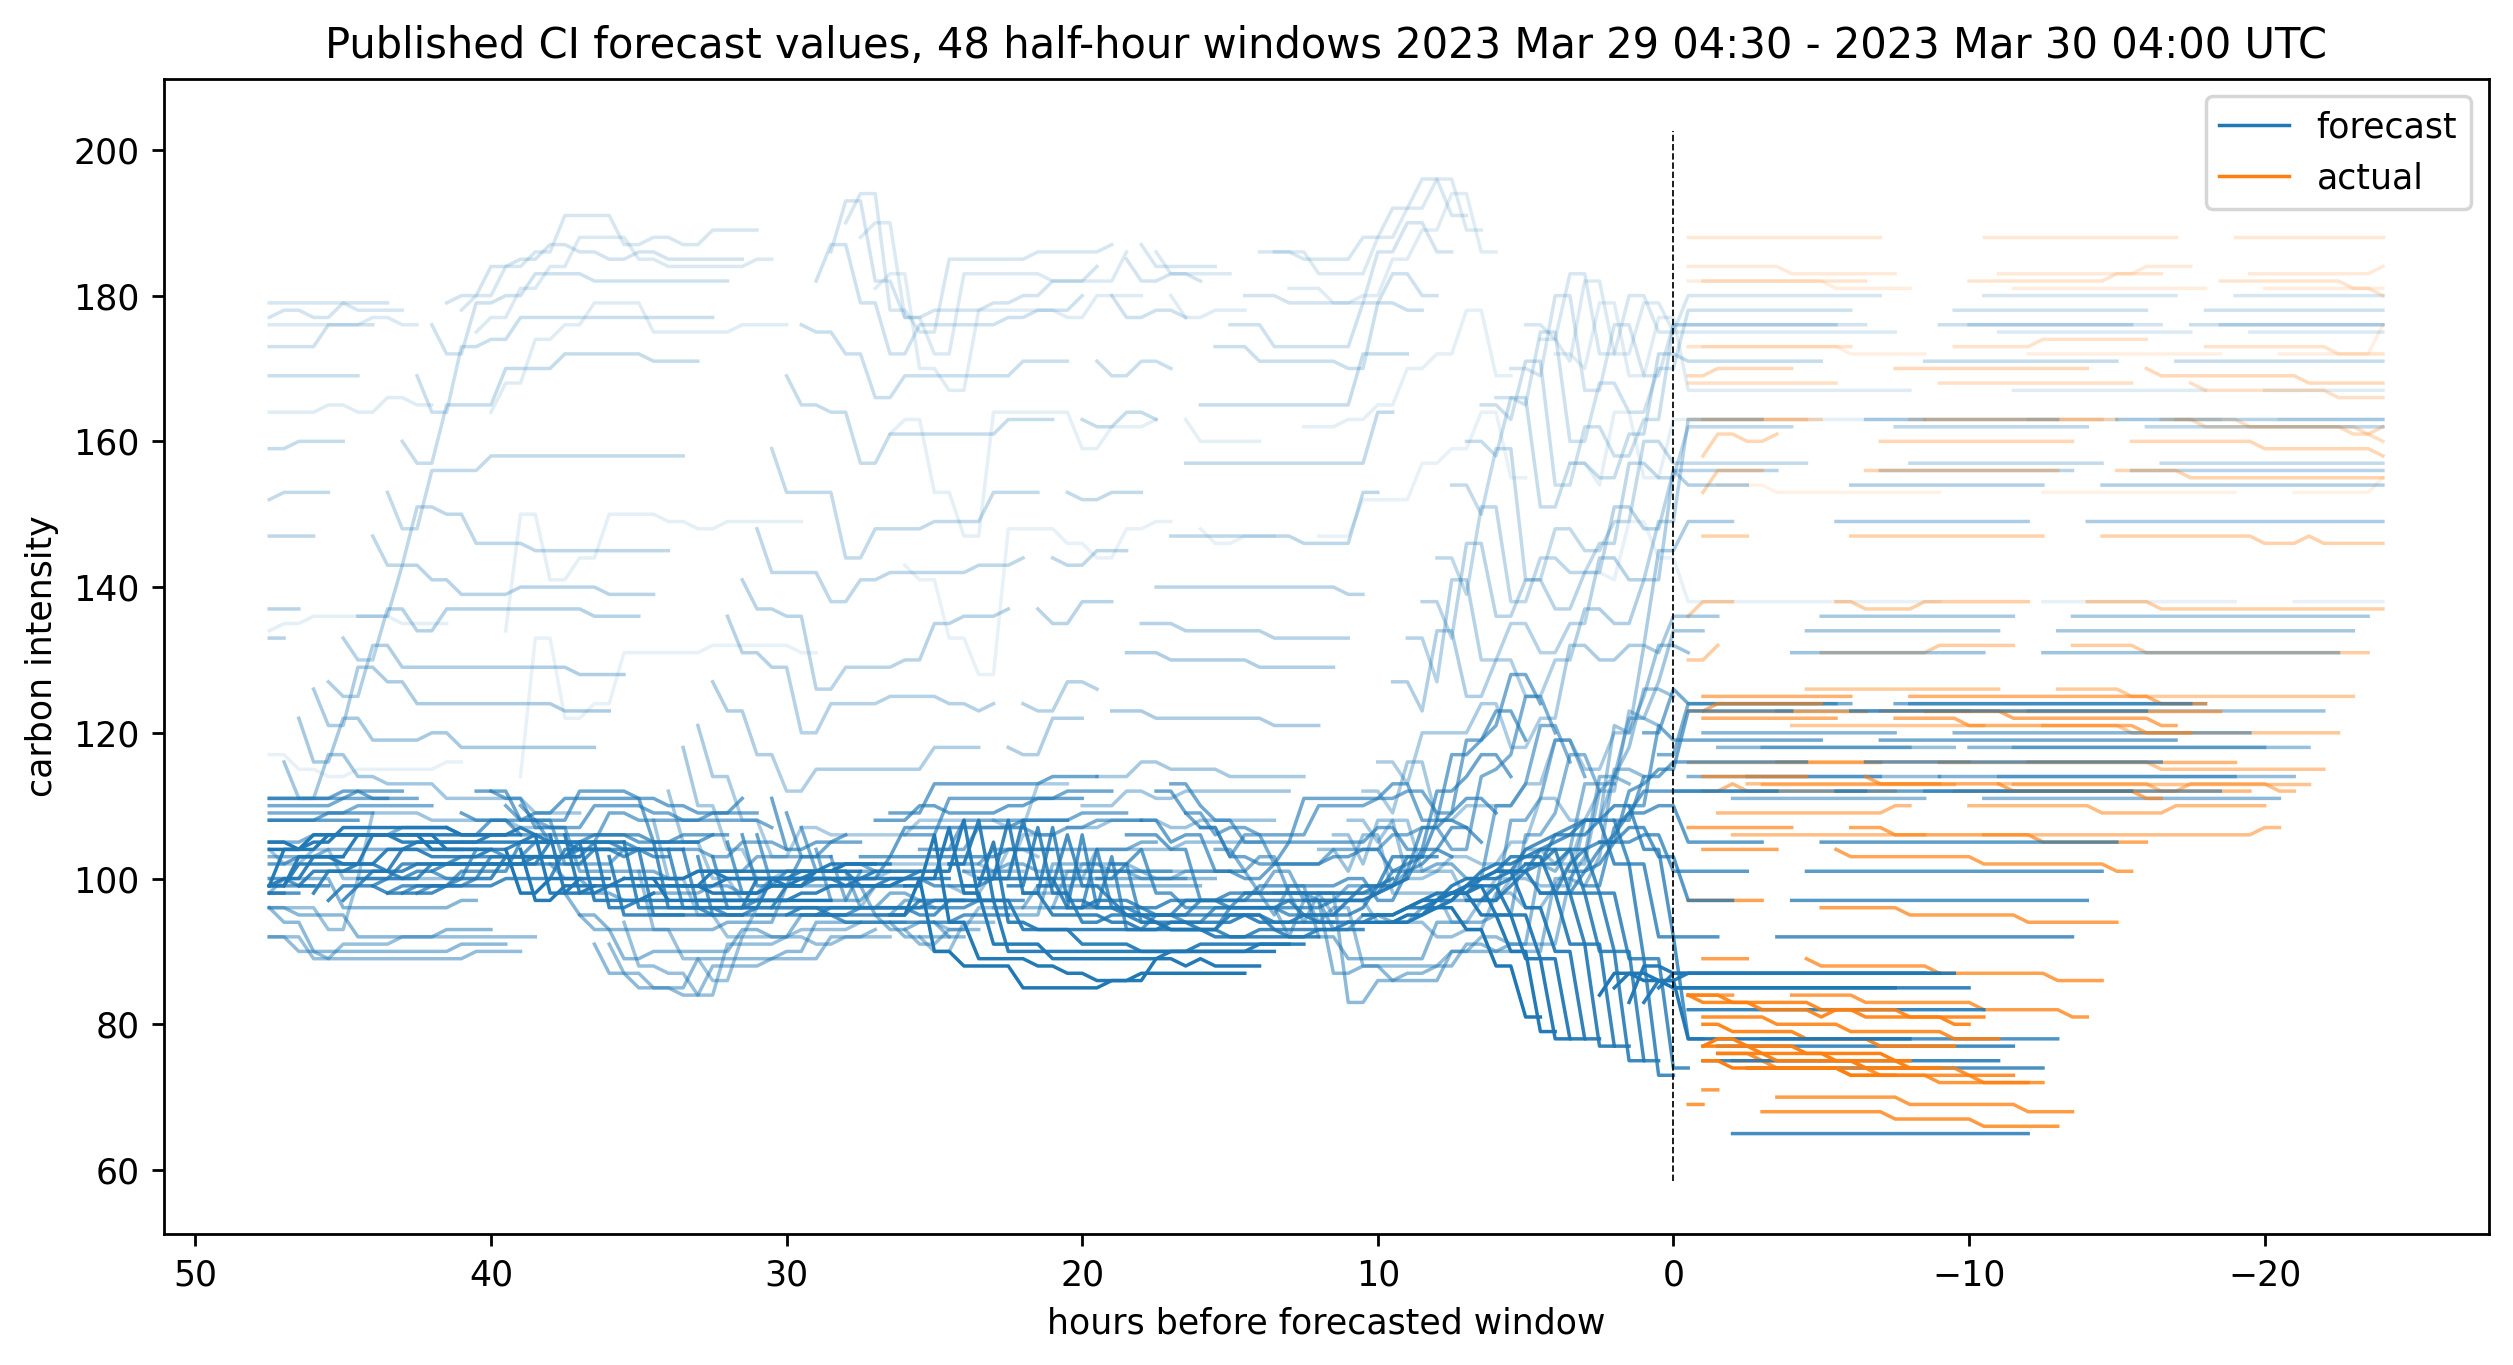

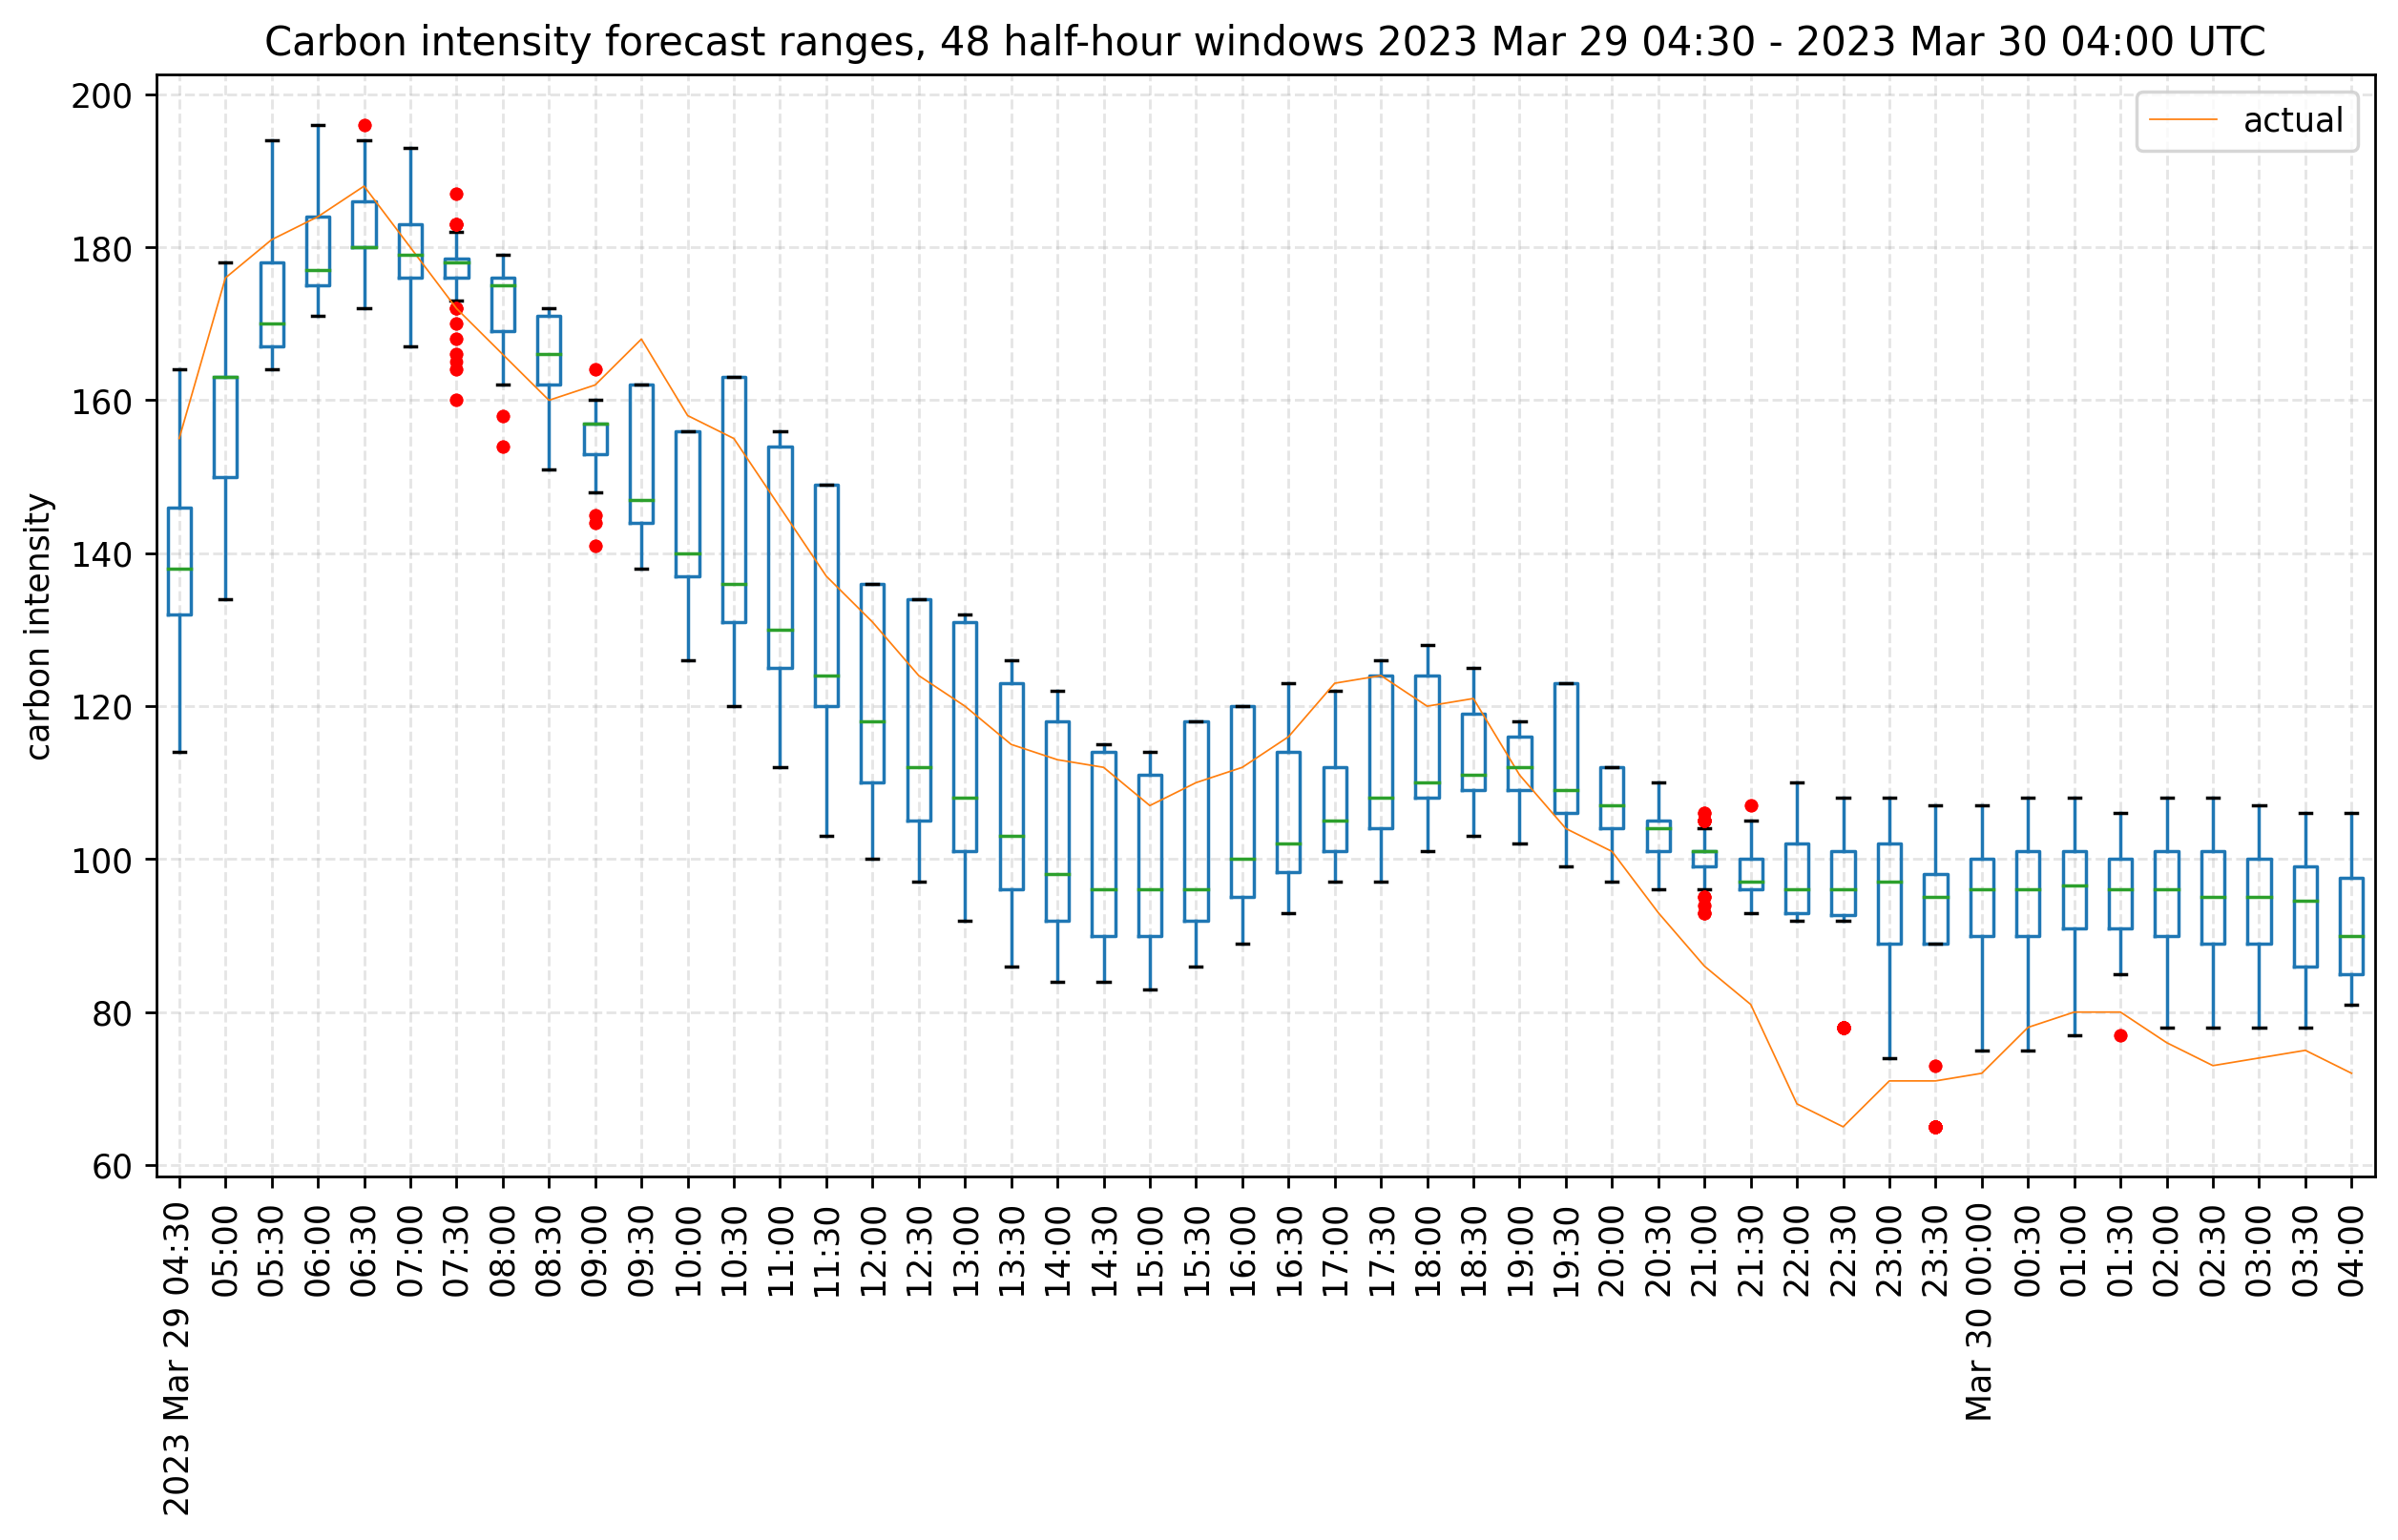

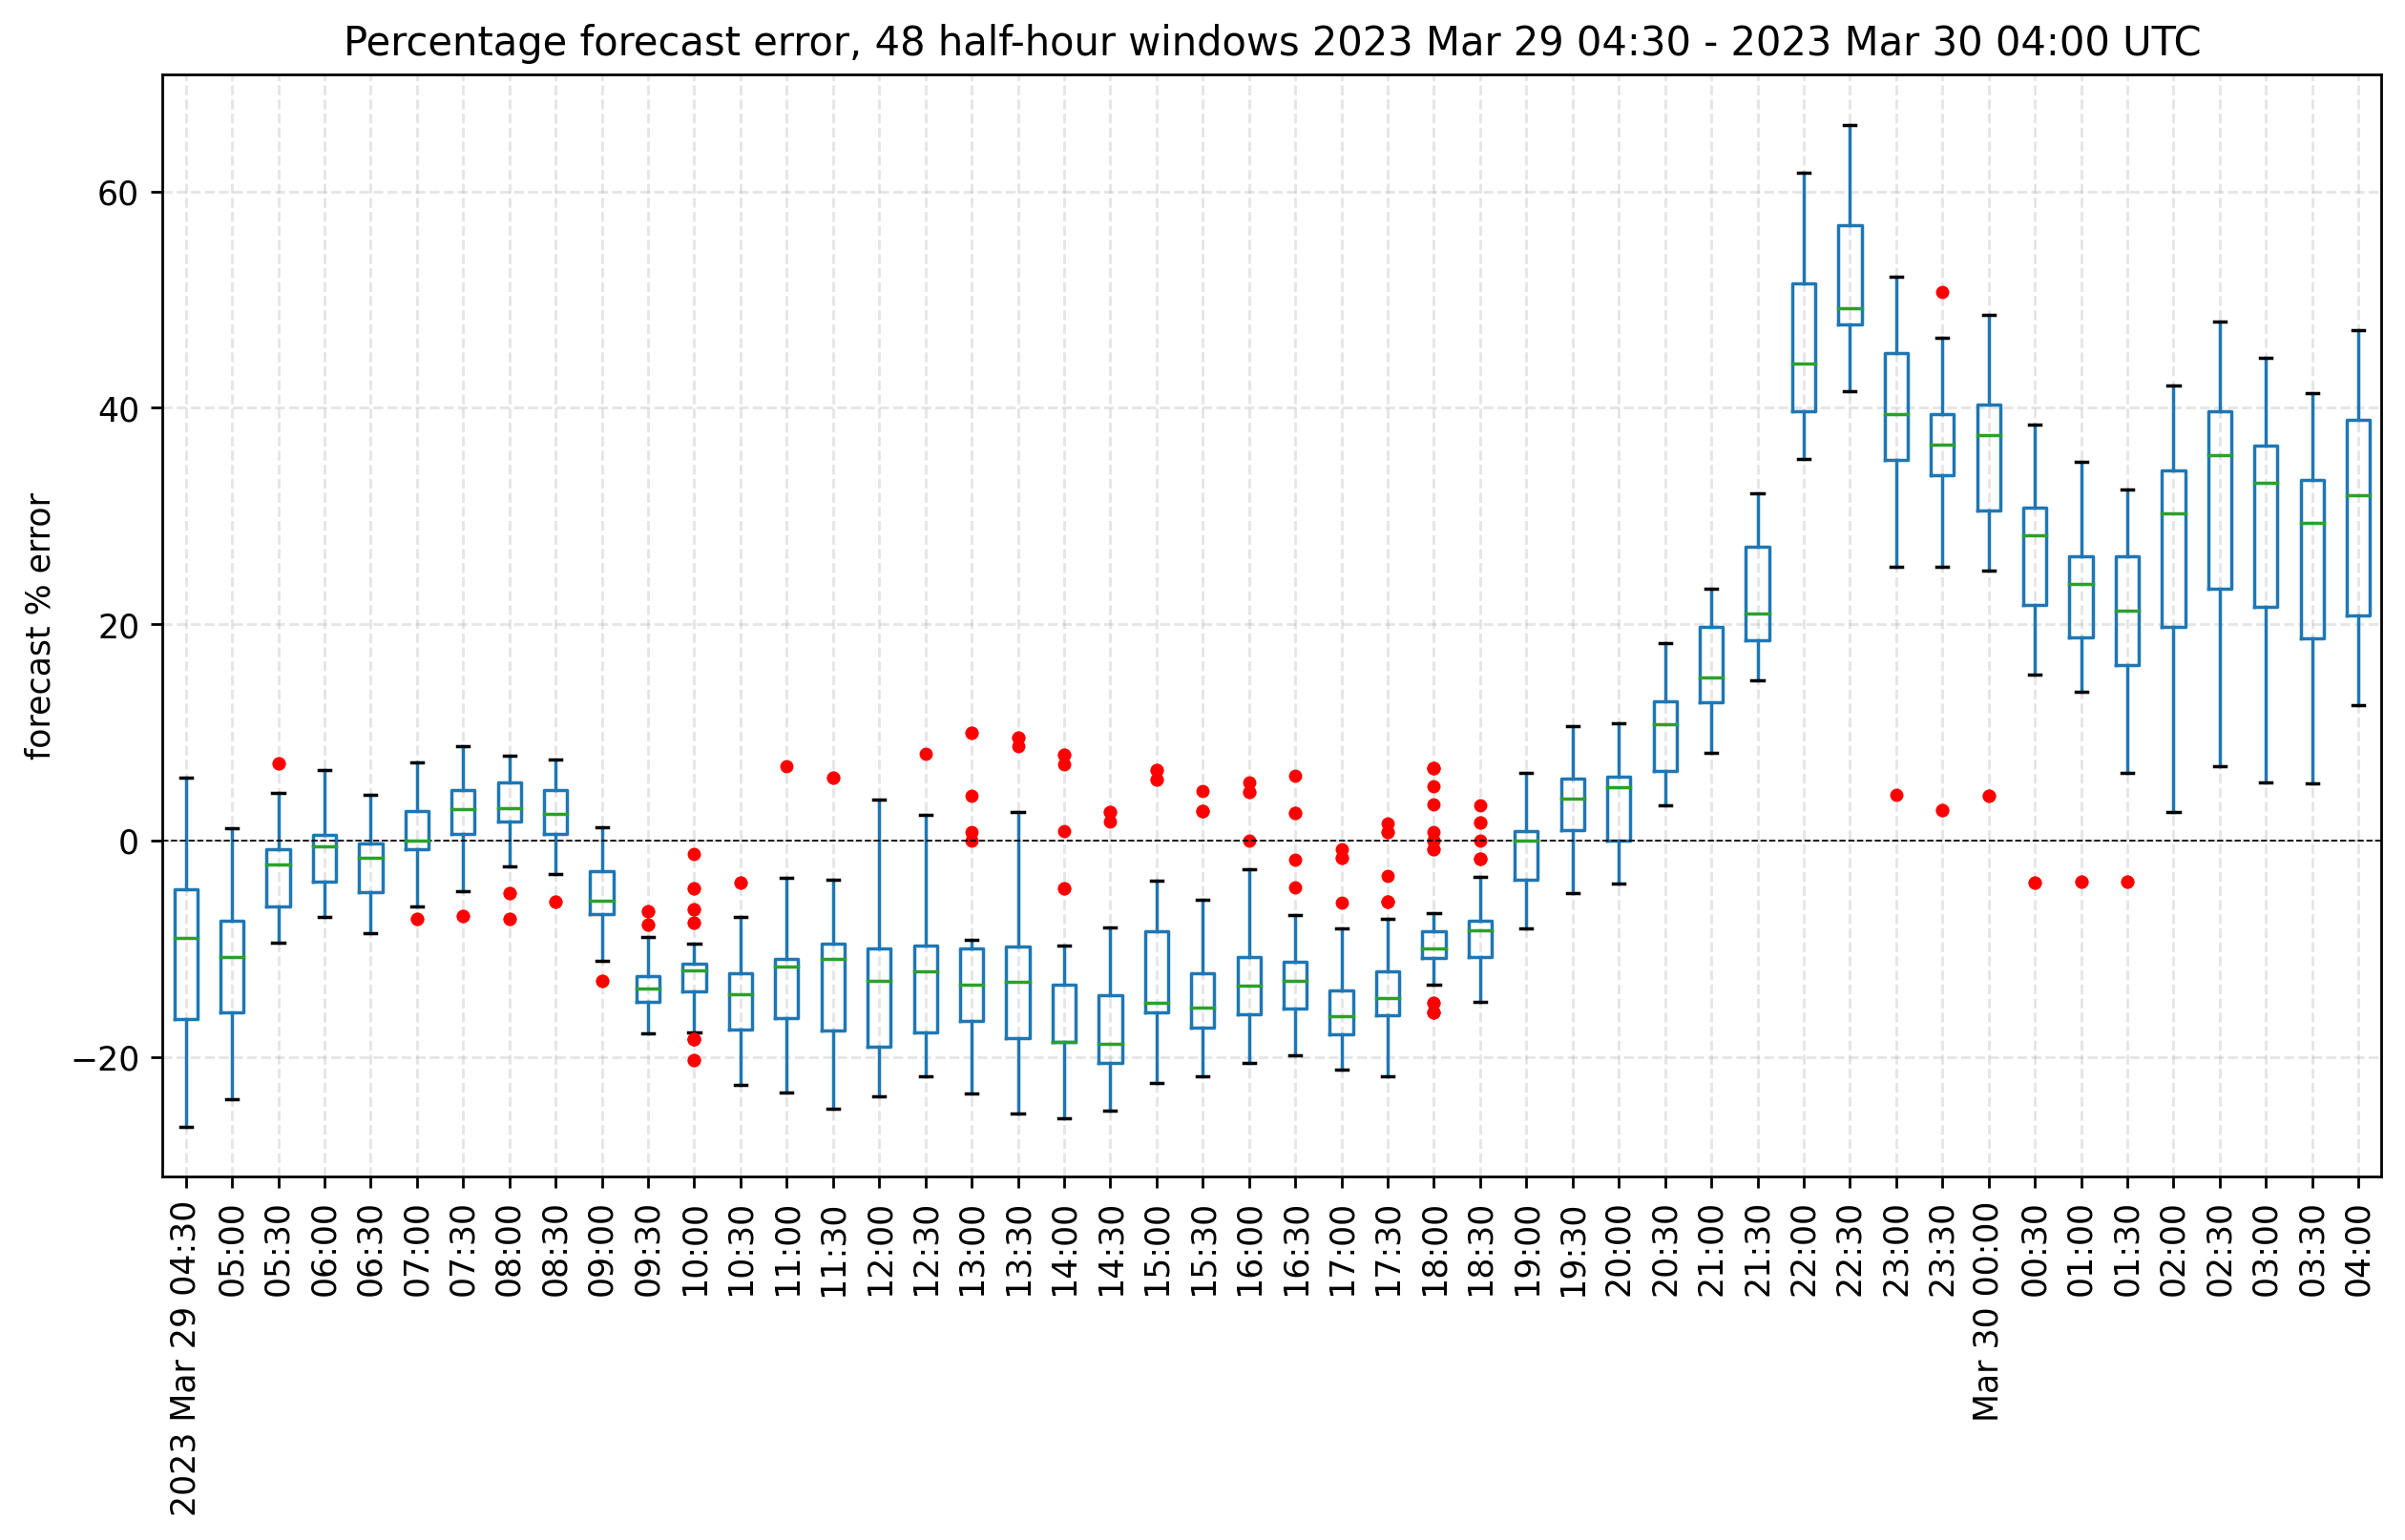

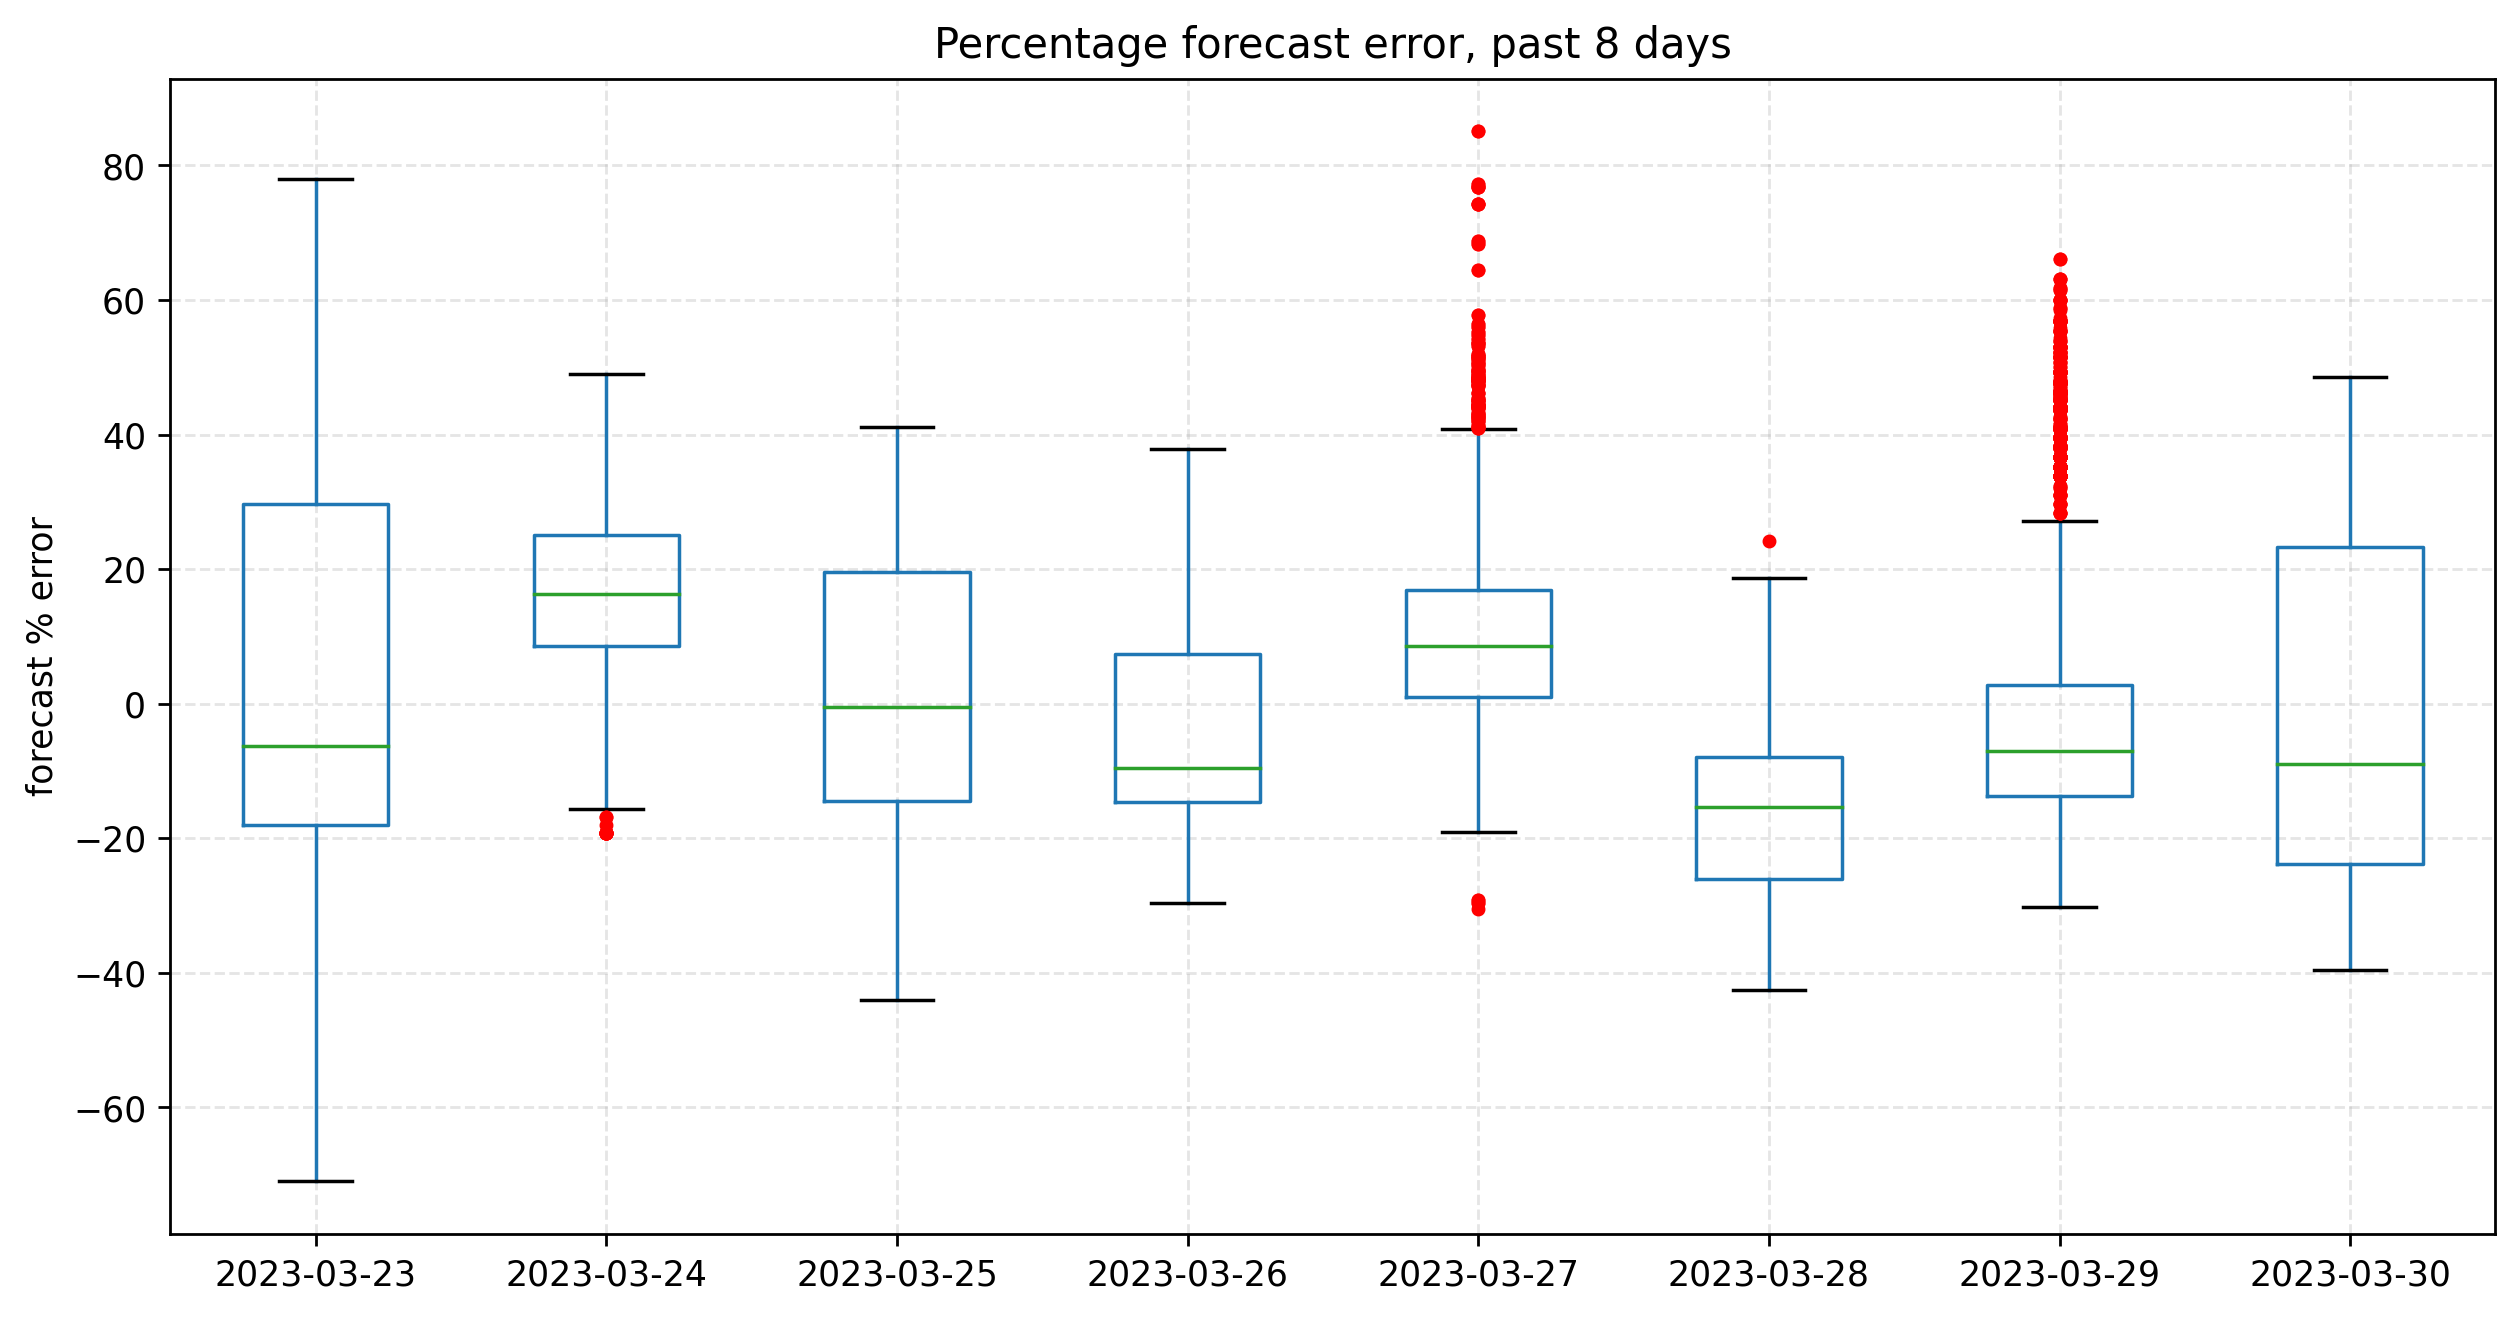

In [2]:
create_graph_images("data", hours_of_data=24)

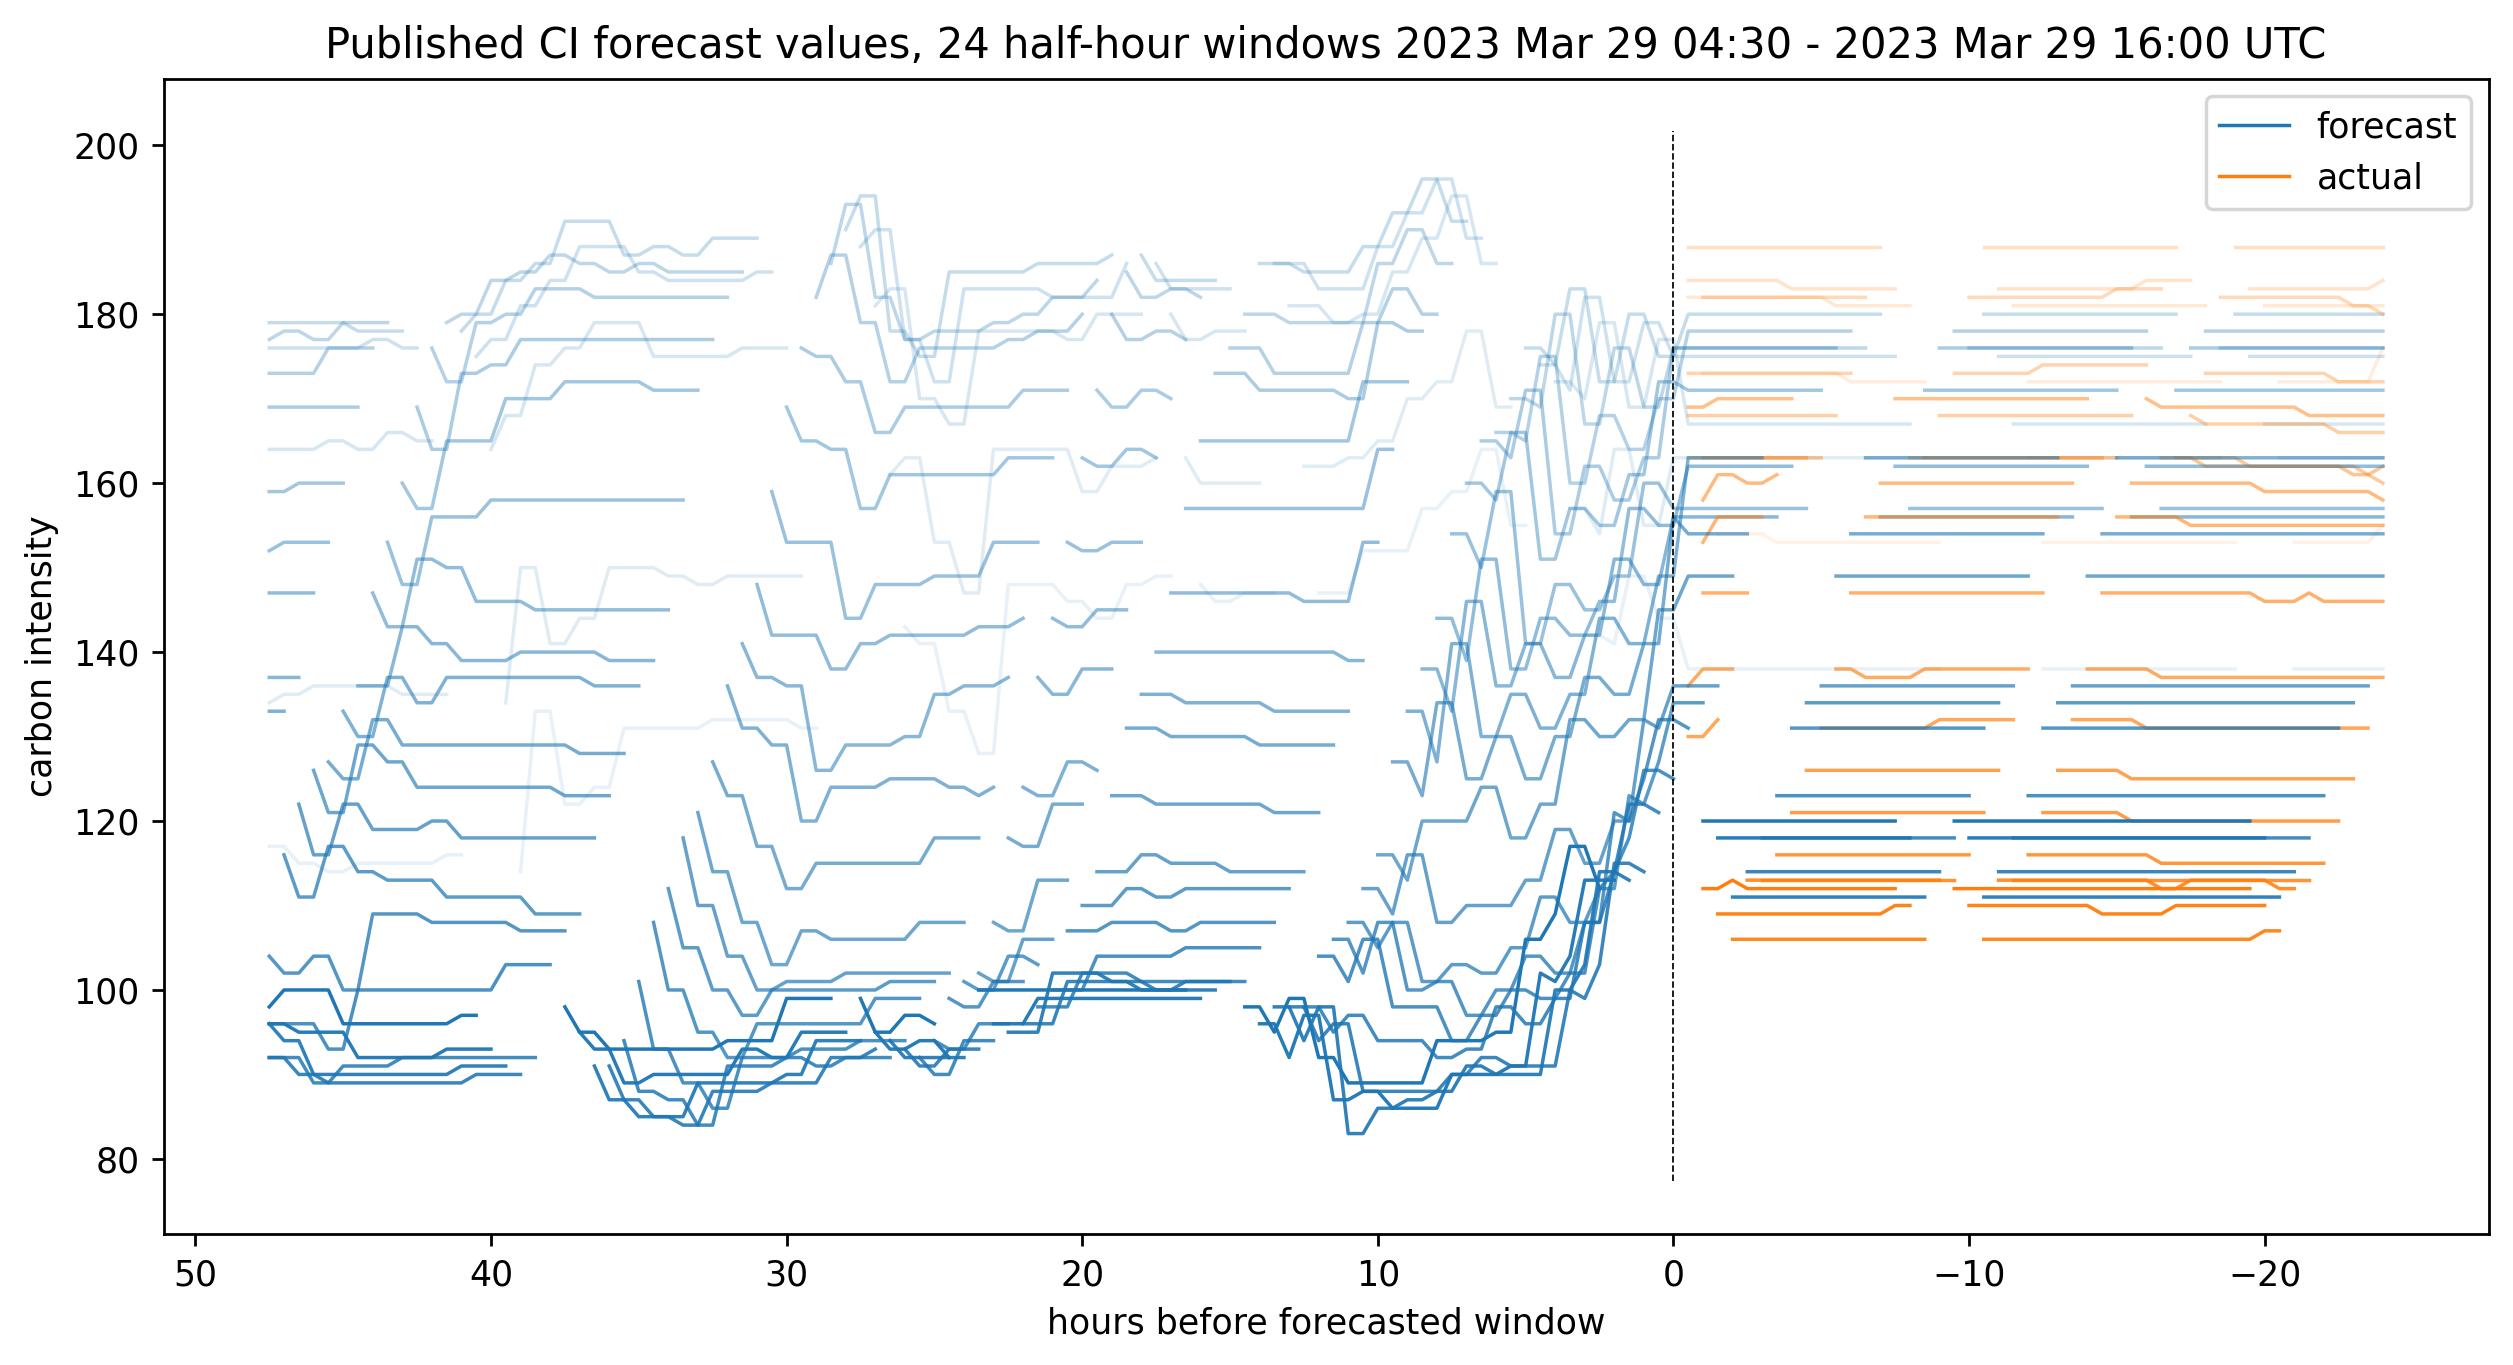

In [3]:
fig = generate_plot_ci_lines("data")

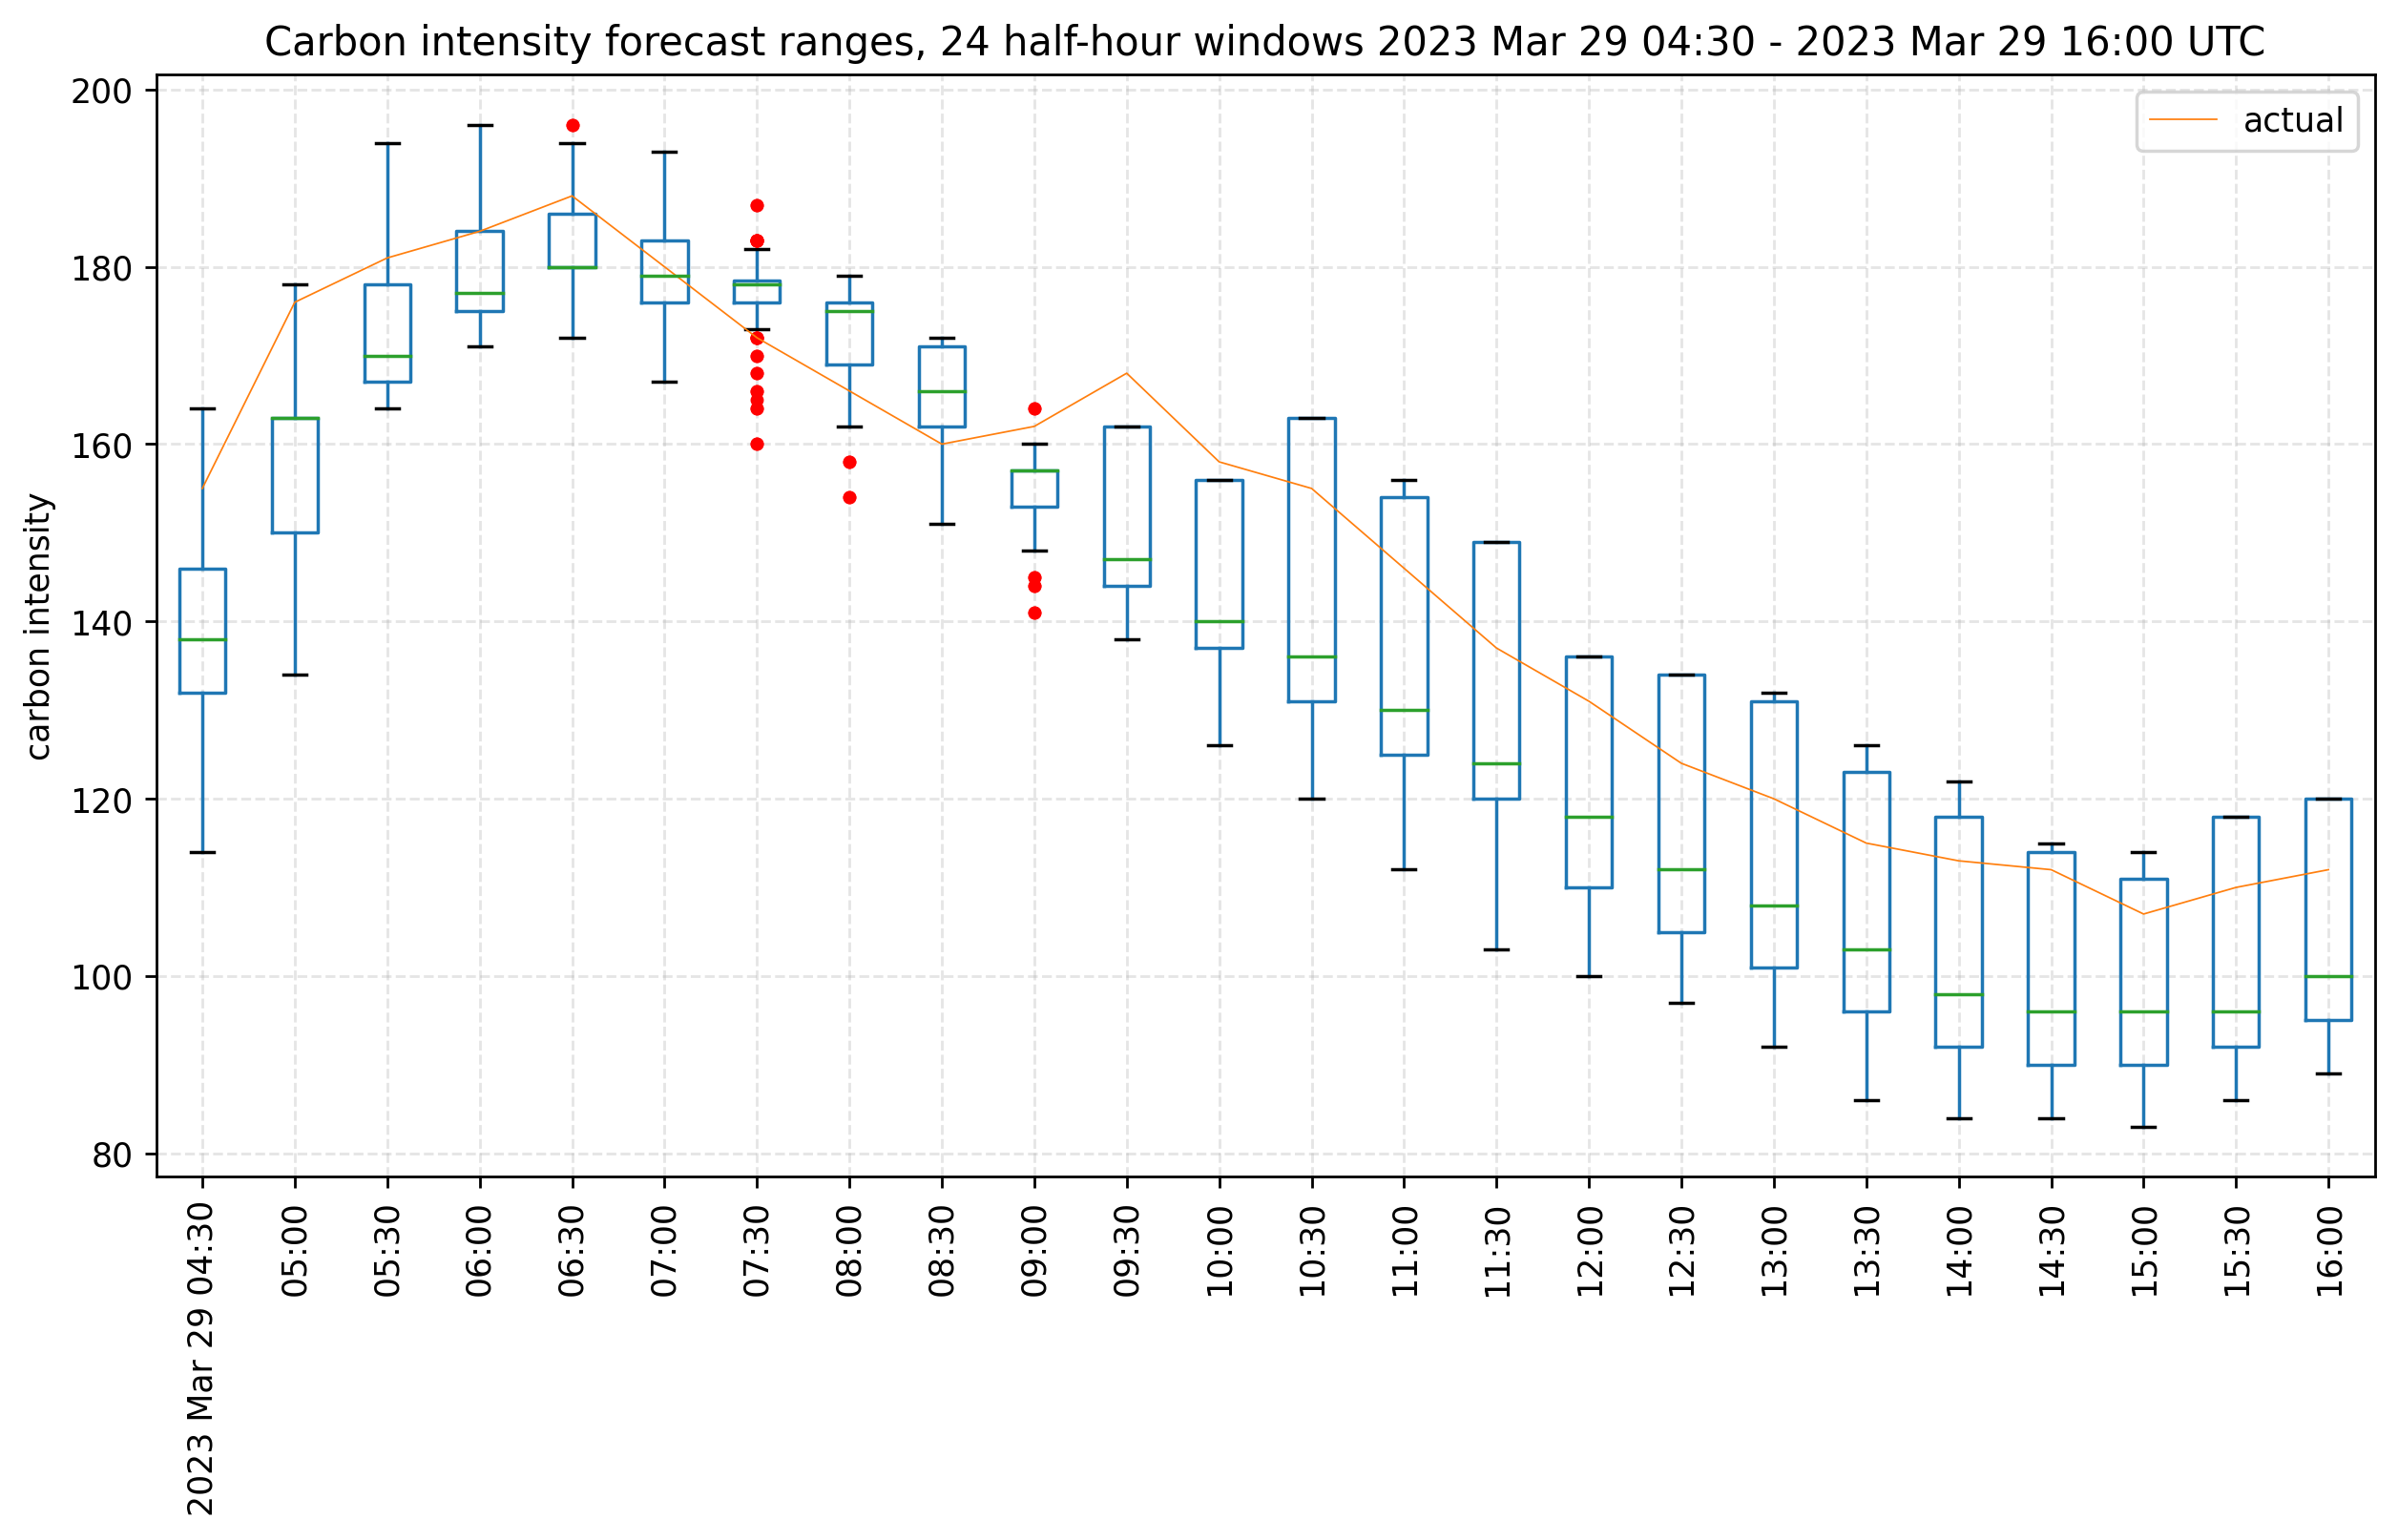

In [4]:
fig = generate_boxplot_ci("data")

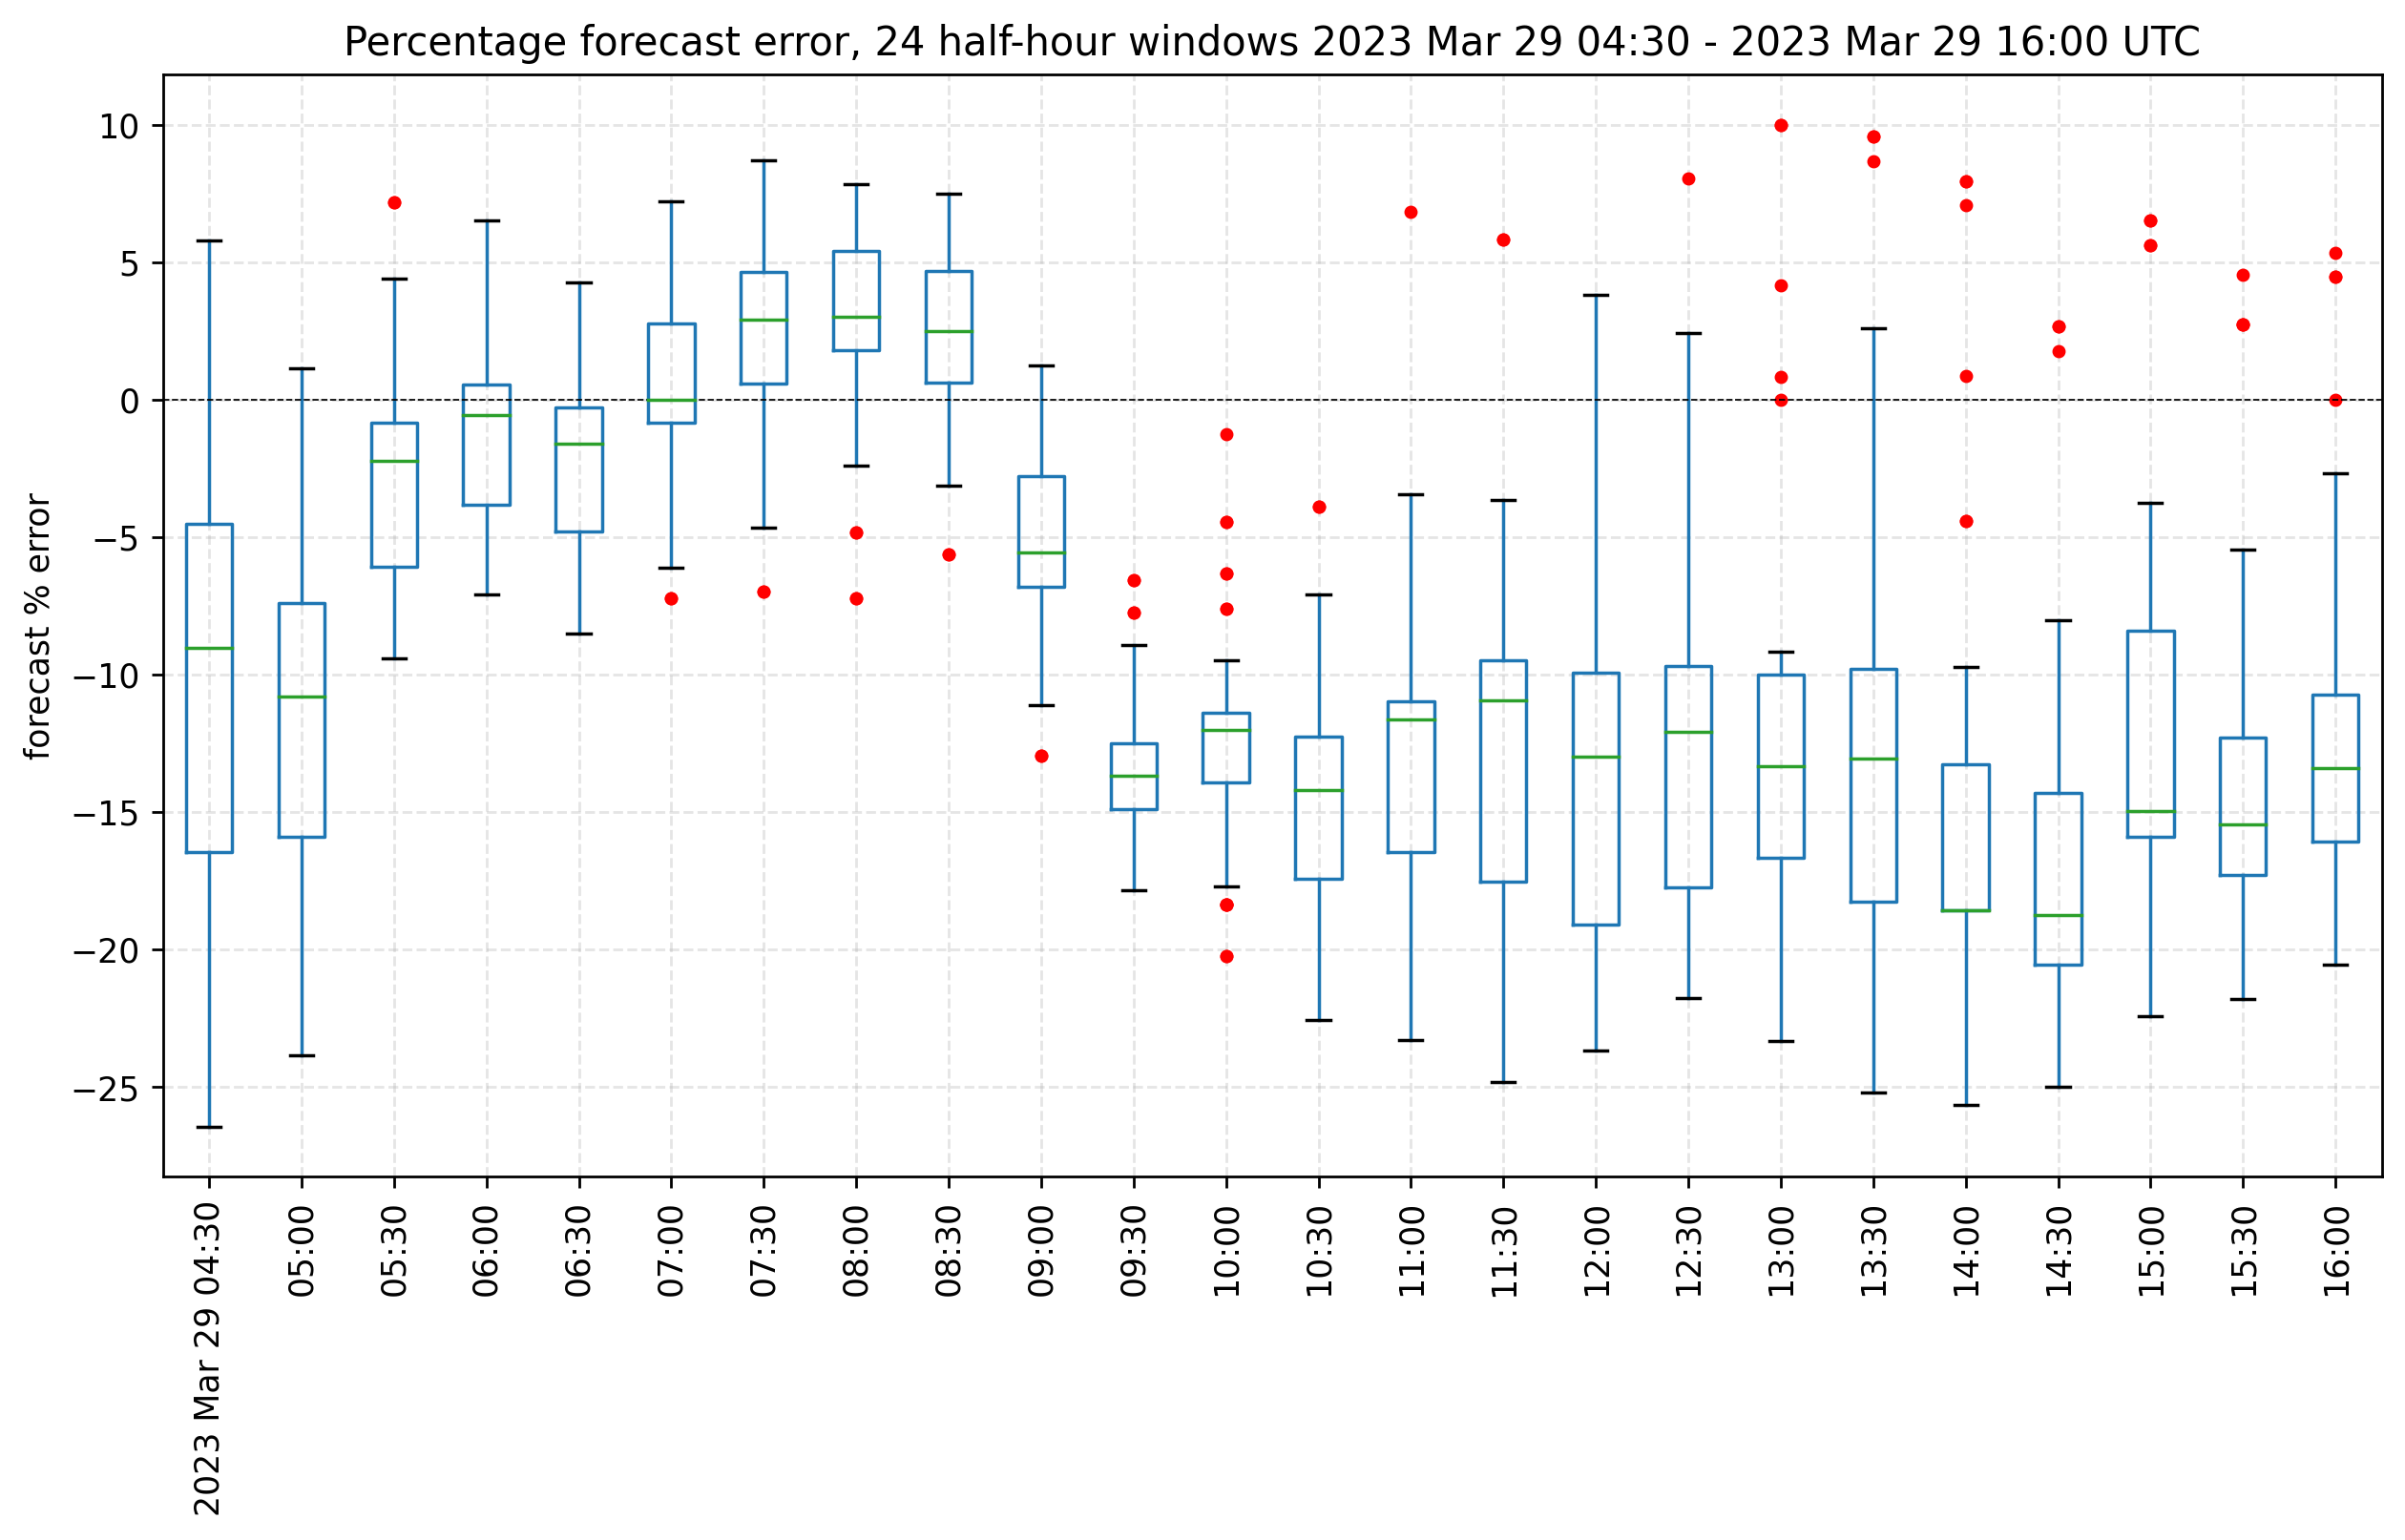

In [5]:
fig = generate_boxplot_ci_error("data")

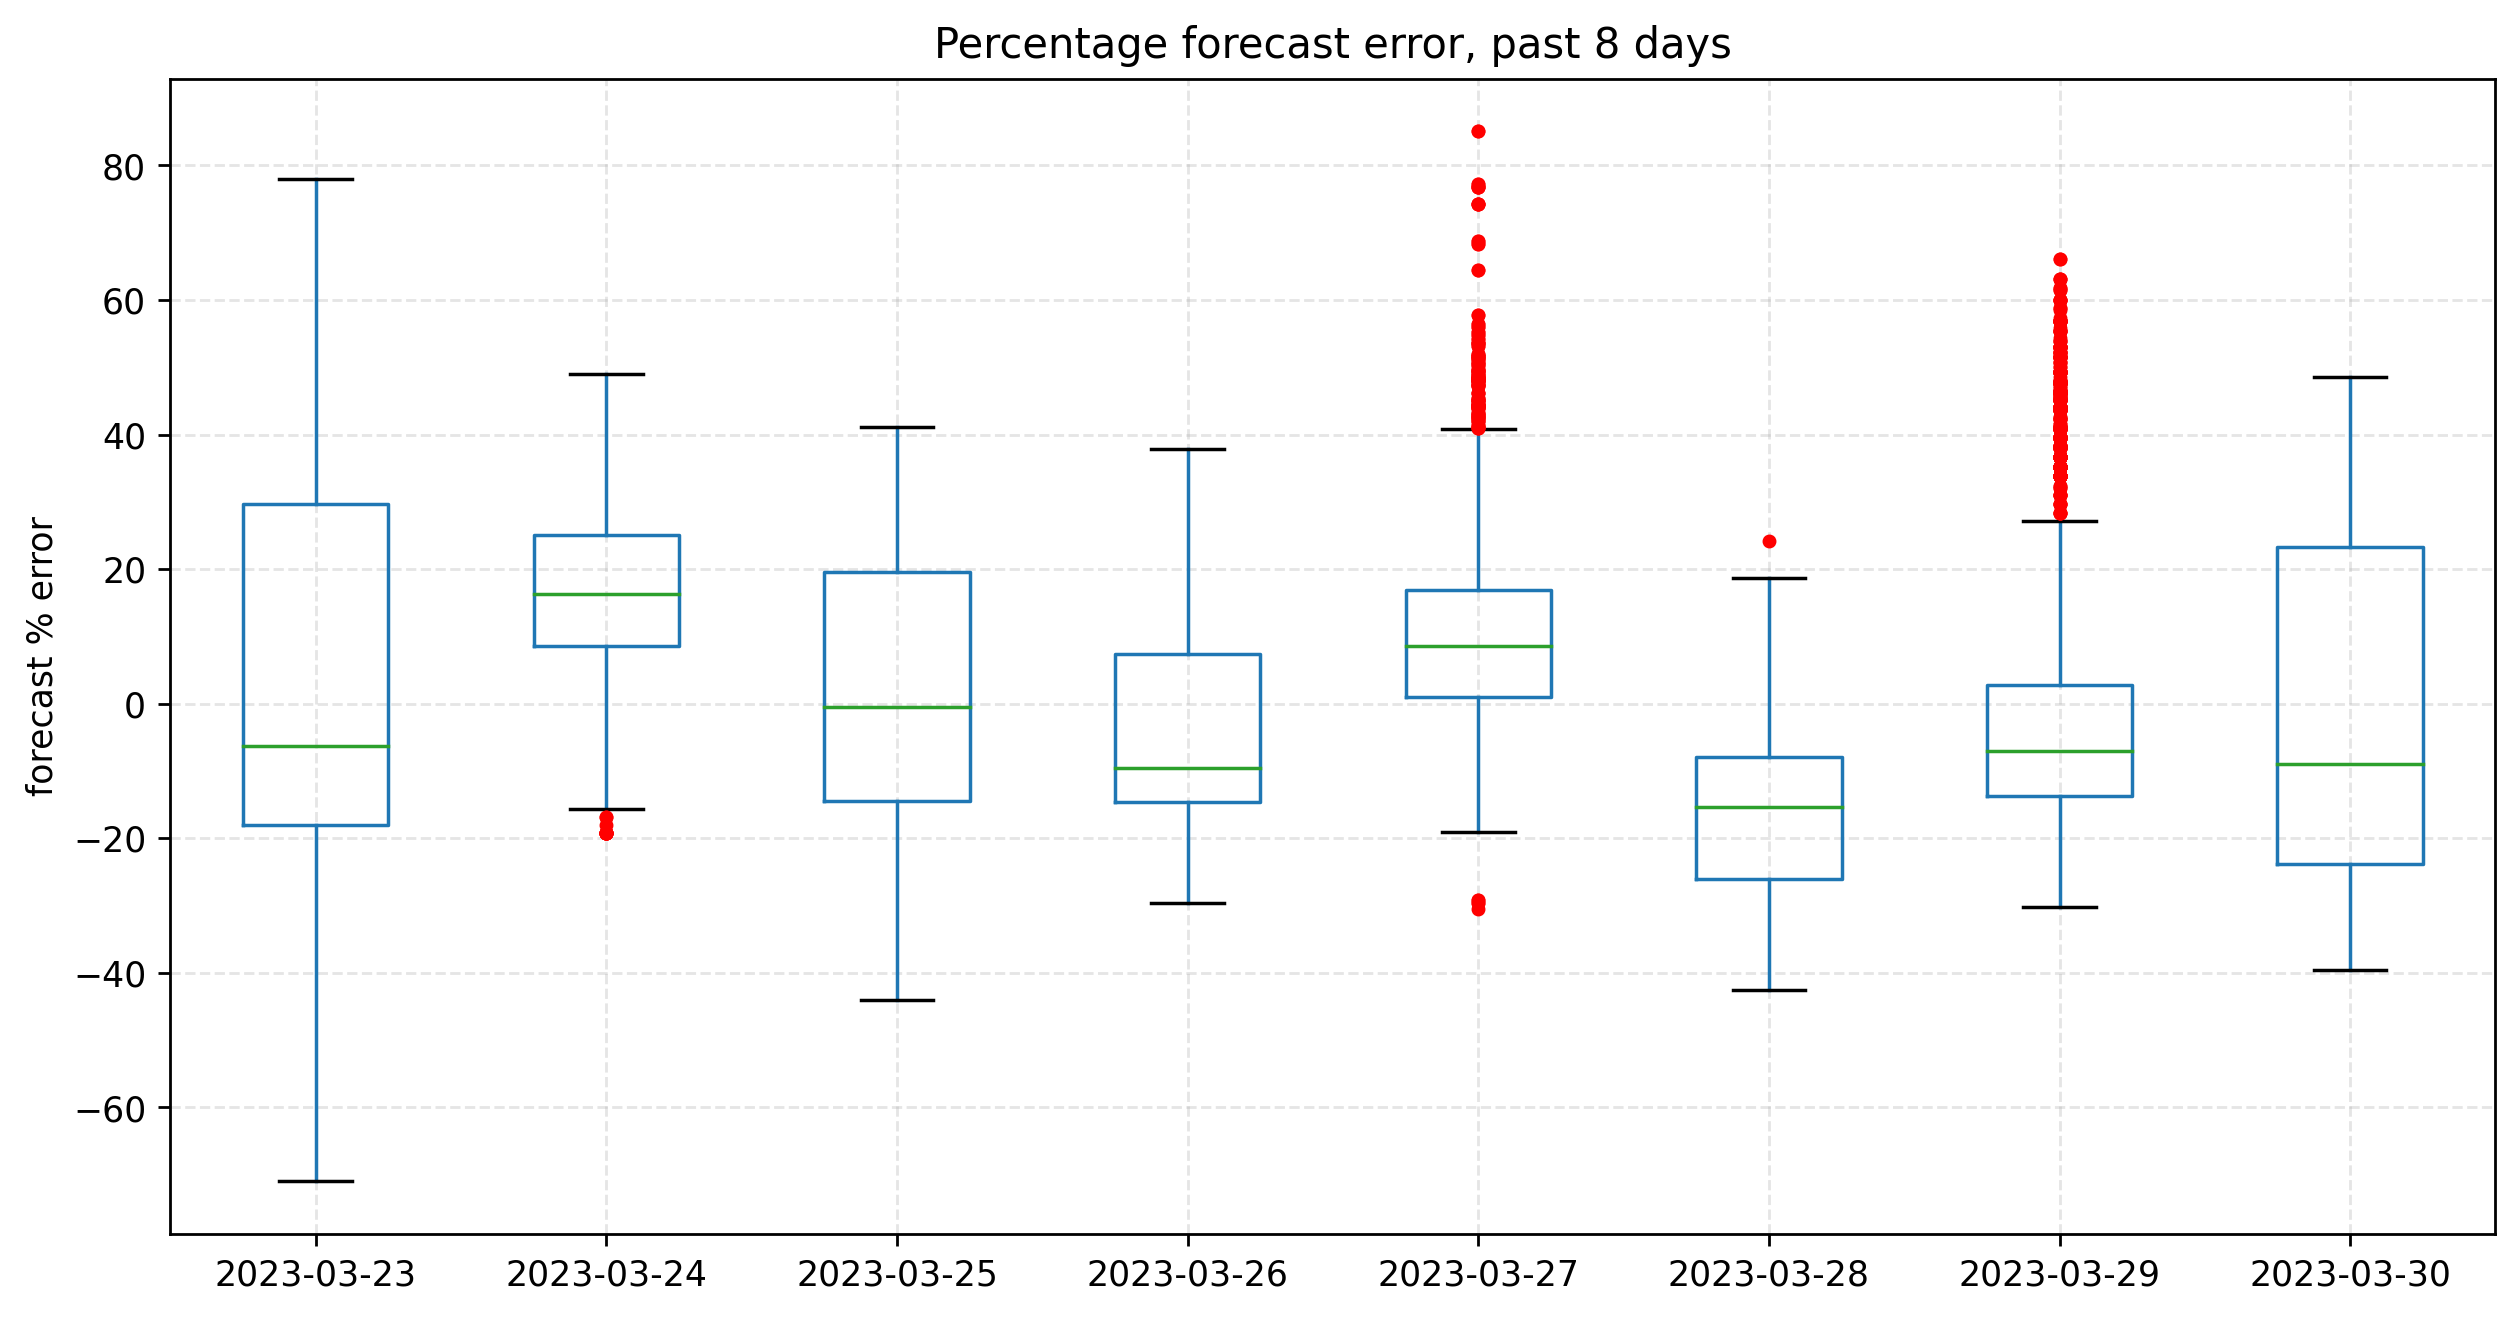

In [6]:
fig = generate_boxplot_ci_error_for_days("data")